In [1]:
import numpy as np
import pandas as pd
import dataframe_image as dfi
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
import joblib

# DATA AND FUNCTIONS

In [2]:
# Load the dataset
data = pd.read_csv(r"revisedLoL_matchdata.csv")

# Drop an 'index' column that is there by my data collection mistake
data = data.drop(['index'],axis=1)

# Default red team Id = 200. Change the red team ID to 0 and blue to 1. 
data['winning_team'] = data['winning_team'].replace([200,100],[0,1])
data.head(5)

,game_id,winning_team,in_game_time,ally_top_level,ally_jgl_level,ally_mid_level,ally_bot_level,ally_sup_level,enemy_top_level,enemy_jgl_level,...,dragon_killed,dragon_lost,voidgrub_killed,voidgrub_lost,riftherald_killed,riftherald_lost,baron_killed,baron_lost,champion_killed,champion_death
0,7358388756,0.0,10.003517,7.0,7.0,7.0,8.0,5.0,8.0,6.0,...,0,1,0,1,0,0,0,0,1,2
1,7358388756,0.0,13.004633,9.0,8.0,8.0,9.0,7.0,9.0,9.0,...,0,1,0,3,0,1,0,0,1,7
2,7358388756,0.0,15.277683,10.0,9.0,9.0,10.0,7.0,11.0,10.0,...,0,1,0,6,0,1,0,0,5,17
3,7347700848,0.0,10.003133,8.0,7.0,9.0,7.0,5.0,7.0,7.0,...,0,0,0,3,0,0,0,0,2,2
4,7347700848,0.0,13.004267,11.0,8.0,10.0,8.0,6.0,8.0,8.0,...,0,1,0,3,1,0,0,0,3,4


In [3]:
# Feature and Response
X = data.drop(['game_id','winning_team'],axis=1)
Y = data['winning_team']

In [4]:
# K-Fold object
k_folds = KFold(n_splits=5, shuffle = True, random_state = 123)

In [5]:
# Define a function to compute the ECE
def ECE_score(y, class1_proba, num_bins=10):
    # class1_proba: an array of probability belonging to class 1 
    # y: an array of observed outcome

    prob_true,prob_pred = calibration_curve(y, class1_proba, n_bins = num_bins)
    ECE = 0
    
    num_bins = len(prob_true)
    
    for bin in range(num_bins):
        # count how many samples are in current bin
        bin_count = len(class1_proba[(class1_proba >= bin/num_bins) & (class1_proba <= (bin+1)/num_bins)])
        
        # add the weighted absolute difference between true and estimated probability of each bin
        ECE += bin_count * abs(prob_true[bin] - prob_pred[bin])
        
    # return the normalize ECE by sample size
    return ECE/len(class1_proba)

# TRAINING

In [6]:
# Split the training data into train/validation/test set. The split is 60/20/20
# Validation set used to calibrate the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 123)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size = 0.25, shuffle = True, random_state = 789)

In [7]:
# scaler object
scaler = StandardScaler().fit(x_train)

In [8]:
## Train the model. Params C was found using 5-fold CV.
#LR = LogisticRegression(C = 0.0144, max_iter = 1000).fit(scaler.transform(x_train),y_train)
#RF = RandomForestClassifier(max_depth = 9, oob_score = True, n_jobs = -1).fit(x_train,y_train)
#SVM = LinearSVC(C = 0.00212, max_iter = 1000, dual = False).fit(scaler.transform(x_train),y_train)

## Saving the trained model. Uncomment to use when needed 
#joblib.dump(LR,'LR.pkl')
#joblib.dump(RF,'RF.pkl')
#joblib.dump(SVM, 'SVM.pkl')

## Loading the trained model. Uncomment to use when needed
LR = joblib.load('LR.pkl')
RF = joblib.load('RF.pkl')
SVM = joblib.load('SVM.pkl')

# Train a dummy model.
Dummy = DummyClassifier(strategy ='most_frequent').fit(x_train,y_train)

# Calibration

In [9]:
## Calibrate previously trained models using Platt scaling.
#LR_cal = CalibratedClassifierCV(LR, cv = 'prefit', n_jobs = -1).fit(scaler.transform(x_val),y_val)
#RF_cal = CalibratedClassifierCV(RF, cv = 'prefit', n_jobs = -1).fit(x_val,y_val)
#SVM_cal = CalibratedClassifierCV(SVM, cv ='prefit', n_jobs = -1).fit(scaler.transform(x_val),y_val)

## Saving the trained model. Uncomment to use when needed 
#joblib.dump(LR_cal,'LR_cal.pkl')
#joblib.dump(RF_cal,'RF_cal.pkl')
#joblib.dump(SVM_cal, 'SVM_cal.pkl')


## Loading the calibration models. Uncomment to use when needed
LR_cal = joblib.load('LR_cal.pkl')
RF_cal = joblib.load('RF_cal.pkl')
SVM_cal  = joblib.load('SVM_cal.pkl')

# Metric

### ACCURACY AND ECE

In [10]:
# Model predictions on test set
LR_pred = LR.predict(scaler.transform(x_test))
RF_pred = RF.predict(x_test)
SVM_pred = SVM.predict(scaler.transform(x_test))

LR_cal_pred = LR_cal.predict(scaler.transform(x_test))
RF_cal_pred = RF_cal.predict(x_test)
SVM_cal_pred = SVM_cal.predict(scaler.transform(x_test))

# Model prediction probability on test set. 
# Only care about the probability of belong in class 1
LR_proba = LR.predict_proba(scaler.transform(x_test))[:,1]
RF_proba = RF.predict_proba(x_test)[:,1]
# SVM model does not have a probability estimate

# Calibration method can assign a probability to SVM models.
LR_cal_proba = LR_cal.predict_proba(scaler.transform(x_test))[:,1]
RF_cal_proba = RF_cal.predict_proba(x_test)[:,1]
SVM_cal_proba = SVM_cal.predict_proba(scaler.transform(x_test))[:,1]

In [11]:
# Accuracy on train set
trainDummy_acc = accuracy_score(y_train,Dummy.predict(x_train))
trainLR_acc = accuracy_score(y_train, LR.predict(scaler.transform(x_train)))
trainRF_acc = accuracy_score(y_train, RF.predict(x_train))
trainSVM_acc = accuracy_score(y_train, SVM.predict(scaler.transform(x_train)))

# ECE on train set
trainLR_ece = ECE_score(y_train, LR.predict_proba(scaler.transform(x_train))[:,1])
trainRF_ece = ECE_score(y_train, RF.predict_proba(x_train)[:,1])

# Compute train score for calibrated models. Doesn't work with cross_val_score for some reason:
#for 

trainLR_cal_acc = accuracy_score(y_train, LR_cal.predict(scaler.transform(x_train)))
trainRF_cal_acc = accuracy_score(y_train, RF_cal.predict(x_train))
trainSVM_cal_acc = accuracy_score(y_train, SVM_cal.predict(scaler.transform(x_train)))

# ECE on train set
trainLR_cal_ece = ECE_score(y_train, LR_cal.predict_proba(scaler.transform(x_train))[:,1])
trainRF_cal_ece = ECE_score(y_train, RF_cal.predict_proba(x_train)[:,1])
trainSVM_cal_ece = ECE_score(y_train, SVM_cal.predict_proba(scaler.transform(x_train))[:,1])



In [12]:
# Accuracy on test set
testDummy_acc = accuracy_score(y_test,Dummy.predict(x_test))
testLR_acc = accuracy_score(y_test, LR_pred)
testRF_acc = accuracy_score(y_test, RF_pred)
testSVM_acc = accuracy_score(y_test, SVM_pred)

testLR_cal_acc = accuracy_score(y_test, LR_cal_pred)
testRF_cal_acc = accuracy_score(y_test, RF_cal_pred)
testSVM_cal_acc = accuracy_score(y_test, SVM_cal_pred)

# ECE on test set
testLR_ece = ECE_score(y_test, LR_proba)
testRF_ece = ECE_score(y_test, RF_proba)

testLR_cal_ece = ECE_score(y_test,LR_cal_proba)
testRF_cal_ece = ECE_score(y_test, RF_cal_proba)
testSVM_cal_ece = ECE_score(y_test, SVM_cal_proba)

In [13]:
results_table = pd.DataFrame({'Train Accuracy': np.round([trainLR_acc, trainRF_acc, trainSVM_acc], 3),
                              'Test Accuracy': np.round([testLR_acc, testRF_acc, testSVM_acc], 3), 
                              'Calibrated Train Accuracy': np.round([trainLR_cal_acc, trainRF_cal_acc, trainSVM_cal_acc], 3),
                              'Calibrated Test Accuracy': np.round([testLR_cal_acc, testRF_cal_acc, testSVM_cal_acc], 3),
                              'Train ECE': np.round([trainLR_ece, trainRF_ece, 0], 4),
                              'Test ECE': np.round([testLR_ece, testRF_ece, 0],4),
                              'Calibrated Train ECE': np.round([trainLR_cal_ece, trainRF_cal_ece, trainSVM_cal_ece], 4),
                              'Calibrated Test ECE': np.round([testLR_cal_ece, testRF_cal_ece, testSVM_cal_ece], 4)},
                             index = ['LR', 'RF', 'SVM'])

# Change the 0 for SVM ECE to None
results_table['Train ECE'][2] = None
results_table['Test ECE'][2] = None

# Column for the dummy model
results_table.loc['Dummy'] = [np.round(trainDummy_acc,3), np.round(testDummy_acc,3), None, None, None, None, None, None]
dfi.export(results_table,'model_results.png',dpi=200)
results_table


,Train Accuracy,Test Accuracy,Calibrated Train Accuracy,Calibrated Test Accuracy,Train ECE,Test ECE,Calibrated Train ECE,Calibrated Test ECE
LR,0.850,0.851,0.850,0.851,0.0148,0.0146,0.0149,0.0148
RF,0.861,0.842,0.862,0.843,0.1234,0.1093,0.0113,0.0114
SVM,0.849,0.850,0.850,0.850,NaN,NaN,0.0130,0.0138
Dummy,0.527,0.524,NaN,NaN,NaN,NaN,NaN,NaN


### DIAGRAMS

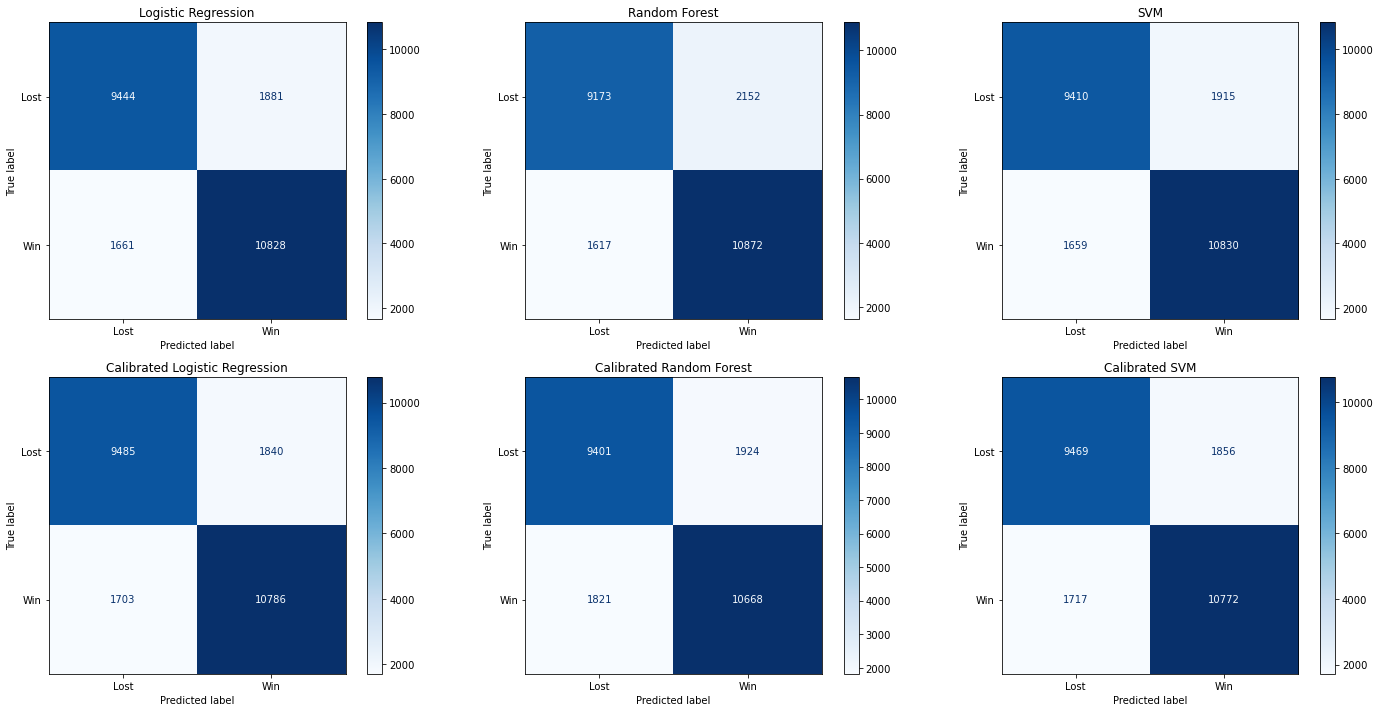

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (20,10))

models = [LR, RF, SVM, LR_cal, RF_cal, SVM_cal]
models_name = ['Logistic Regression', 'Random Forest', 'SVM', 
               'Calibrated Logistic Regression', 'Calibrated Random Forest', 'Calibrated SVM']
for model, name, ax in zip(models, models_name, axes.flatten()):
    if model in [RF,RF_cal]:
        plot_confusion_matrix(model, x_test, y_test, ax=ax, display_labels=['Lost', 'Win'], cmap='Blues')
    else:
        plot_confusion_matrix(model, scaler.transform(x_test), y_test, ax=ax, display_labels=['Lost', 'Win'],cmap='Blues')
    ax.title.set_text(name)
    
plt.tight_layout()  
plt.show()

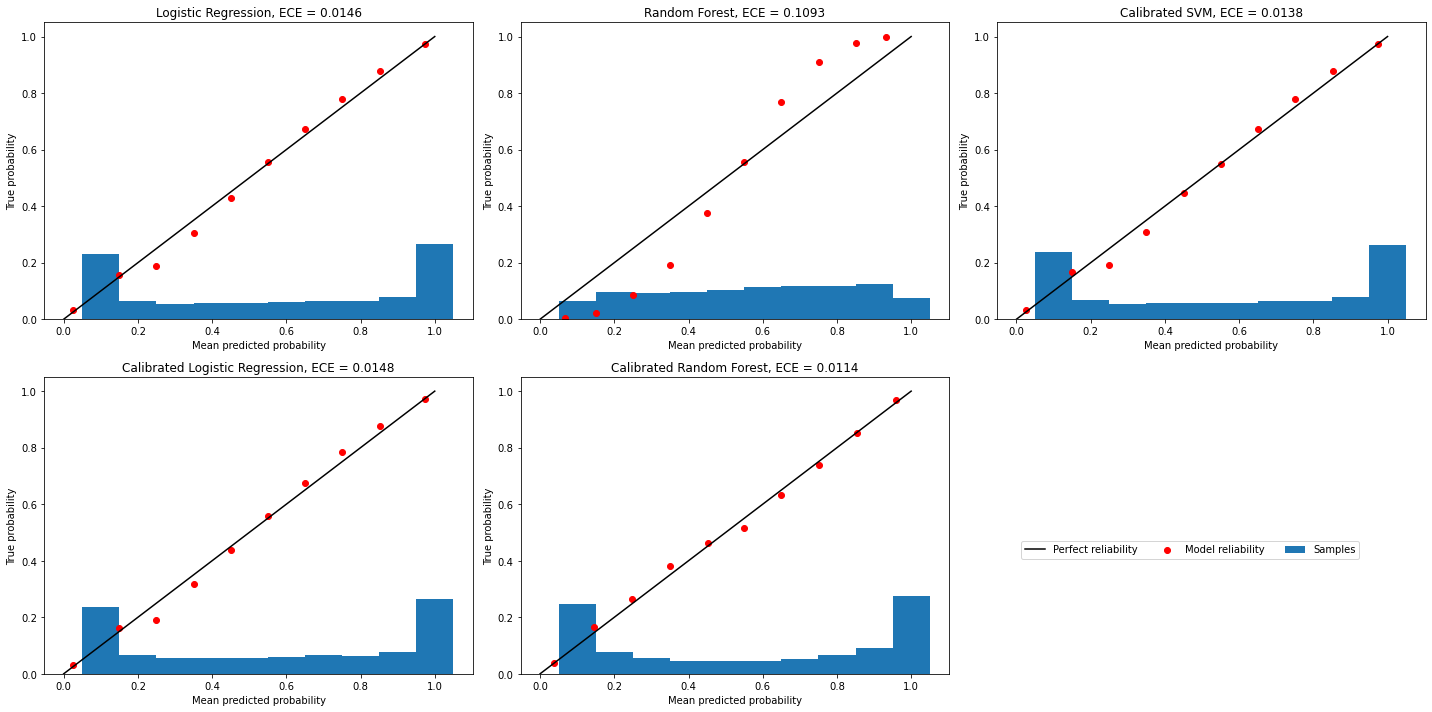

In [15]:
# Perfect calibration line
x = np.linspace(0,1)
y = x

fig2, axes2 = plt.subplots(nrows=2, ncols=3, figsize = (20,10))

models_proba = [LR_proba, RF_proba, SVM_cal_proba, LR_cal_proba, RF_cal_proba, ]
models_ece = [testLR_ece, testRF_ece, testSVM_cal_ece, testLR_cal_ece, testRF_cal_ece,]
models_name = ['Logistic Regression', 'Random Forest', 'Calibrated SVM', 
               'Calibrated Logistic Regression', 'Calibrated Random Forest']

for proba, ece, name, ax in zip(models_proba, models_ece, models_name, axes2.flatten()):
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins = 10)
    num_bins = len(prob_true)
    bin_count = [len(proba[(proba >= bin/num_bins) & 
                           (proba <= (bin+1)/num_bins)]) for bin in range(num_bins)]
    ax.bar(np.arange(0.1,1.1,0.1),np.array(bin_count)/len(proba), width = 0.1, zorder=-1, label='Samples')
    ax.plot(x,y,color='black',label='Perfect reliability')
    ax.scatter(prob_pred,prob_true,color='r', label='Model reliability')
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('True probability')
    ax.title.set_text(f'{name}, ECE = {ece:.4f}')

lines, labels = axes2[0, 0].get_legend_handles_labels()
fig2.legend(lines, labels, ncol=3,bbox_to_anchor=(0.95, 0.25))
fig2.delaxes(axes2[1,2])
plt.tight_layout()
plt.show()

# SCORE AS FUNCTION OF IN-GAME TIME

In [16]:
# Game stages dict
# Key is a time interval in the game, e.g [10,13). Up to [37,40) and everything else is 40+
game_stages_X = {f'[{i},{i+3})': x_test[(x_test['in_game_time'] >= i) & (x_test['in_game_time'] < i+3)] for i in range(10,40,3)}
game_stages_X['40+'] = x_test[x_test['in_game_time'] >= 40]

In [17]:
LR_acc_over_time = [accuracy_score(y_test[game_stages_X[time_interval].index], 
                                   LR.predict(scaler.transform(game_stages_X[time_interval])))
                    for time_interval in game_stages_X]
RF_acc_over_time = [accuracy_score(y_test[game_stages_X[time_interval].index], 
                                   RF.predict(game_stages_X[time_interval]))
                    for time_interval in game_stages_X]
SVM_acc_over_time = [accuracy_score(y_test[game_stages_X[time_interval].index], 
                                   SVM.predict(scaler.transform(game_stages_X[time_interval])))
                    for time_interval in game_stages_X]
Dummy_acc_over_time = [accuracy_score(y_test[game_stages_X[time_interval].index], 
                                   Dummy.predict(game_stages_X[time_interval]))
                    for time_interval in game_stages_X]

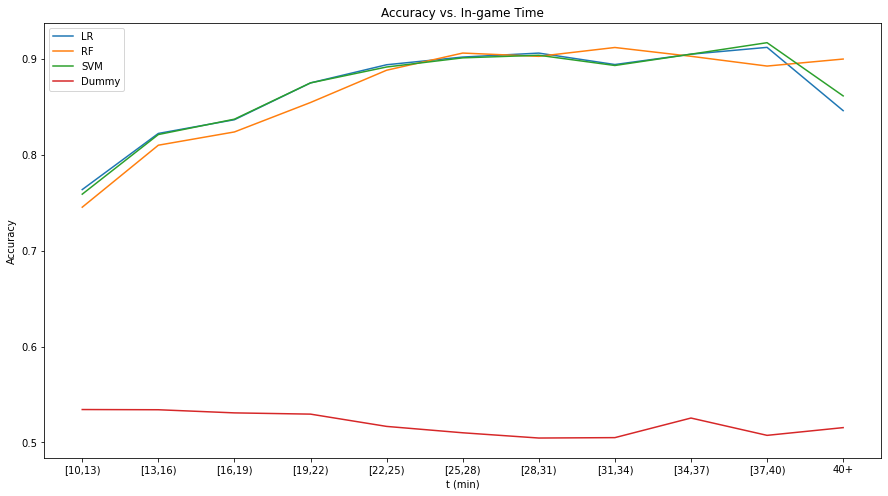

In [18]:
time_intervals = game_stages_X.keys()

fig = plt.figure()
fig.set_size_inches(15,8)

plt.plot(time_intervals, LR_acc_over_time, label = 'LR')
plt.plot(time_intervals, RF_acc_over_time, label = 'RF')
plt.plot(time_intervals, SVM_acc_over_time, label = 'SVM')
plt.plot(time_intervals, Dummy_acc_over_time, label = 'Dummy')
plt.xlabel('t (min)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. In-game Time')
plt.legend()
plt.show()


In [19]:
LR_ece_over_time = [ECE_score(y_test[game_stages_X[time_interval].index], 
                                   LR.predict_proba(scaler.transform(game_stages_X[time_interval]))[:,1])
                    for time_interval in game_stages_X]
RF_ece_over_time = [ECE_score(y_test[game_stages_X[time_interval].index], 
                                   RF_cal.predict_proba(game_stages_X[time_interval])[:,1])
                    for time_interval in game_stages_X]
SVM_ece_over_time = [ECE_score(y_test[game_stages_X[time_interval].index], 
                                   SVM_cal.predict_proba(scaler.transform(game_stages_X[time_interval]))[:,1])
                    for time_interval in game_stages_X]

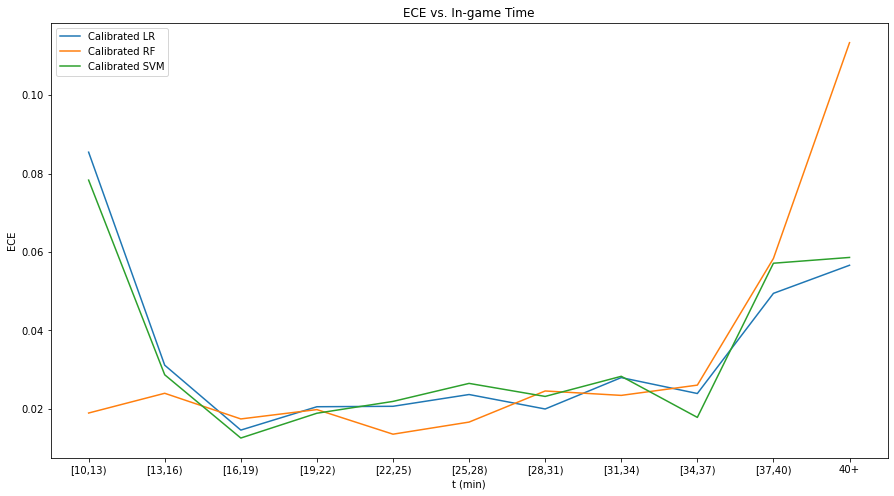

In [20]:
fig = plt.figure()
fig.set_size_inches(15,8)

plt.plot(time_intervals, LR_ece_over_time, label = 'Calibrated LR')
plt.plot(time_intervals, RF_ece_over_time, label = 'Calibrated RF')
plt.plot(time_intervals, SVM_ece_over_time, label = 'Calibrated SVM')
plt.xlabel('t (min)')
plt.ylabel('ECE')
plt.title('ECE vs. In-game Time')
plt.legend()
plt.show()

### TRAIN/TEST IN-GAME TIME DISTRIBUTION

In [21]:
train_bin = [len(x_train[(x_train['in_game_time'] >= i) & 
                 (x_train['in_game_time'] < i+3)]) for i in range(10,40,3)] + \
            [len(x_train[x_train['in_game_time'] > 40])]


train_hist = np.array(train_bin)/len(x_train)

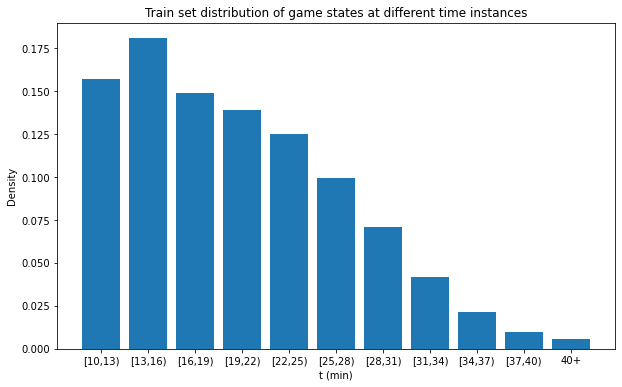

In [22]:
plt.figure(figsize = (10,6))
plt.bar(time_intervals, train_hist)
plt.xlabel('t (min)')
plt.ylabel('Density')
plt.title('Train set distribution of game states at different time instances')
plt.show()

In [23]:
test_bin = [len(x_test[(x_test['in_game_time'] >= i) & 
                 (x_test['in_game_time'] < i+3)]) for i in range(10,40,3)] + \
            [len(x_test[x_test['in_game_time'] > 40])]

test_hist = np.array(train_bin)/len(x_train)


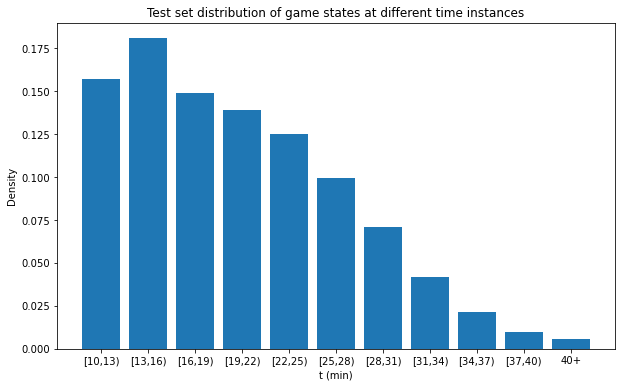

In [24]:
plt.figure(figsize = (10,6))
plt.bar(time_intervals, test_hist)
plt.xlabel('t (min)')
plt.ylabel('Density')
plt.title('Test set distribution of game states at different time instances')
plt.show()

# CASE STUDY: EFFECT OF BARON

In [25]:
# Game states where a baron is killed. If lost, indicate the baron is killed by enemy team. 
after_baron_killed = X[X['baron_killed'].diff() == 1]

# Game states right before a baron is killed. 
before_baron_killed = X.loc[np.array(after_baron_killed.index)-1]

In [26]:
# The estimated win probability before baron capture
win_proba_before_killed = np.array([LR_cal.predict_proba(scaler.transform(before_baron_killed))[:,1],
                                    RF_cal.predict_proba(before_baron_killed)[:,1],
                                    SVM_cal.predict_proba(scaler.transform(before_baron_killed))[:,1]])

# The estimated win probability after a baron capture
win_proba_after_killed  = np.array([LR_cal.predict_proba(scaler.transform(after_baron_killed))[:,1],
                              RF_cal.predict_proba(after_baron_killed)[:,1],
                              SVM_cal.predict_proba(scaler.transform(after_baron_killed))[:,1]])

# The chage in win rate
kill_proba_change = win_proba_after_killed - win_proba_before_killed 

In [27]:
baron_result = pd.DataFrame({'Win Prob. Before': np.mean(win_proba_before_killed,axis=1),
                             'Win Prob. After':  np.mean(win_proba_after_killed,axis=1),
                             'Win Prob. Change': np.mean(kill_proba_change,axis=1)},
                           index = ['LR','RF','SVM'])
baron_result = np.round(baron_result,3)
dfi.export(baron_result,"baron_result.png", dpi = 200)
baron_result

,Win Prob. Before,Win Prob. After,Win Prob. Change
LR,0.679,0.790,0.111
RF,0.678,0.796,0.118
SVM,0.677,0.786,0.109


In [28]:
# ECE scores before baron secured
LR_before_baron_ece = ECE_score(Y.loc[before_baron_killed.index], win_proba_before_killed[0])
RF_before_baron_ece = ECE_score(Y.loc[before_baron_killed.index], win_proba_before_killed[1])
SVM_before_baron_ece = ECE_score(Y.loc[before_baron_killed.index], win_proba_before_killed[2])


# ECE scores after baron secured
LR_after_baron_ece = ECE_score(Y.loc[after_baron_killed.index], win_proba_after_killed[0])
RF_after_baron_ece = ECE_score(Y.loc[after_baron_killed.index], win_proba_after_killed[1])
SVM_after_baron_ece = ECE_score(Y.loc[after_baron_killed.index], win_proba_after_killed[2])


In [29]:
baron_ece = pd.DataFrame({'ECE Before': [LR_before_baron_ece, RF_before_baron_ece, SVM_before_baron_ece],
                          'ECE After': [LR_after_baron_ece, RF_after_baron_ece, SVM_after_baron_ece]},
                        index = ['LR','RF','SVM'])

baron_ece = np.round(baron_ece,4)
dfi.export(baron_ece,'baron_ece.png',dpi=200)
baron_ece

,ECE Before,ECE After
LR,0.1611,0.0511
RF,0.1614,0.0434
SVM,0.1628,0.0538


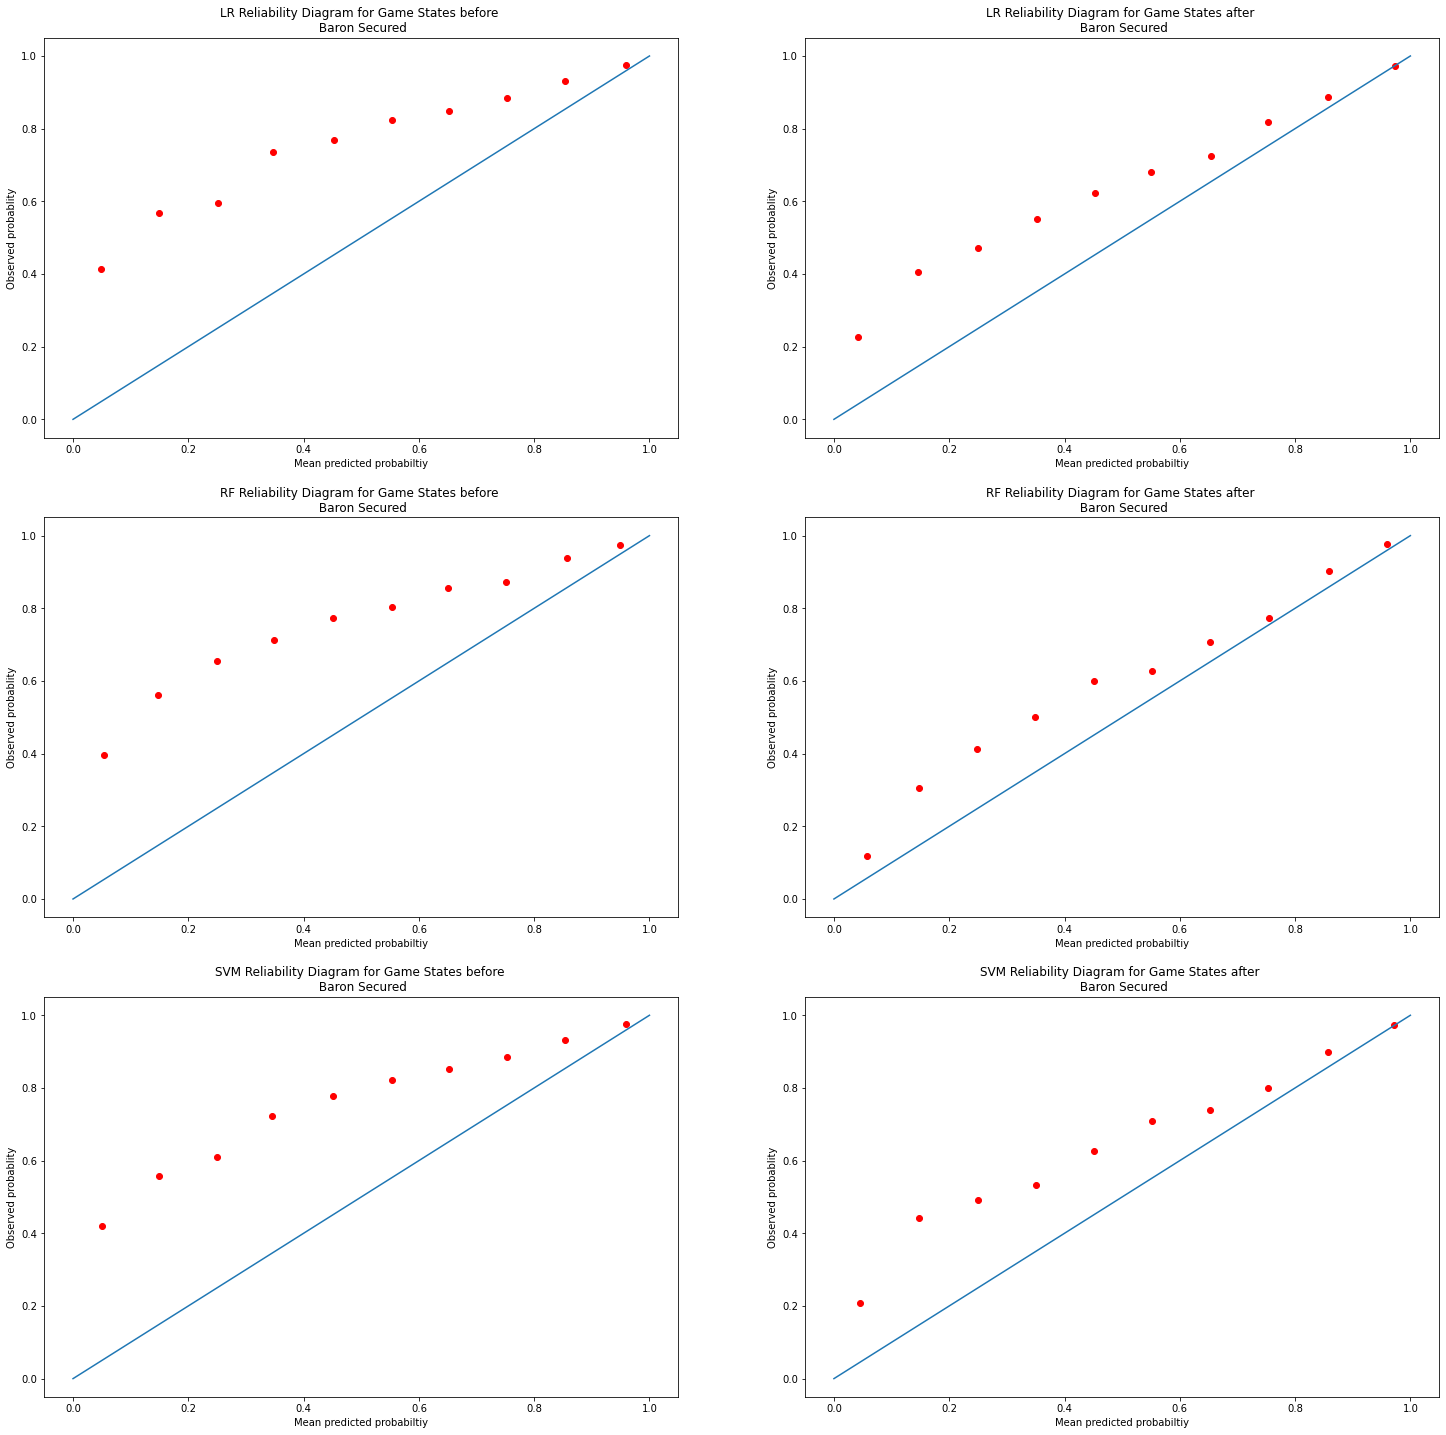

In [30]:
fig3, ax3 = plt.subplots(3,2, figsize = (25,25))


model_names = ['LR','RF', 'SVM']

# plot the relibability diagram before baron
for i in range(3):
    prob_true,prob_pred = calibration_curve(Y.loc[before_baron_killed.index],
                                           win_proba_before_killed[i], n_bins = 10)
    ax3[i,0].plot(x,y)
    ax3[i,0].scatter(prob_pred,prob_true,color='r')
    ax3[i,0].set_xlabel('Mean predicted probabiltiy')
    ax3[i,0].set_ylabel('Observed probablity')
    ax3[i,0].title.set_text(f'{model_names[i]} Reliability Diagram for Game States before \n Baron Secured')

# plot the relibability diagram after baron
for i in range(3):
    prob_true,prob_pred = calibration_curve(Y.loc[before_baron_killed.index],
                                           win_proba_after_killed[i], n_bins = 10)
    ax3[i,1].plot(x,y)
    ax3[i,1].scatter(prob_pred,prob_true,color='r')
    ax3[i,1].set_xlabel('Mean predicted probabiltiy')
    ax3[i,1].set_ylabel('Observed probablity')
    ax3[i,1].title.set_text(f'{model_names[i]} Reliability Diagram for Game States after \n Baron Secured')

In [31]:
before_baron_killed

,in_game_time,ally_top_level,ally_jgl_level,ally_mid_level,ally_bot_level,ally_sup_level,enemy_top_level,enemy_jgl_level,enemy_mid_level,enemy_bot_level,...,dragon_killed,dragon_lost,voidgrub_killed,voidgrub_lost,riftherald_killed,riftherald_lost,baron_killed,baron_lost,champion_killed,champion_death
14,19.005650,12.0,11.0,12.0,11.0,8.0,13.0,10.0,11.0,11.0,...,1,1,0,3,0,1,0,0,15,6
16,25.007050,15.0,14.0,14.0,14.0,11.0,13.0,13.0,14.0,13.0,...,1,2,0,3,0,1,1,0,24,12
18,31.008817,17.0,16.0,16.0,16.0,12.0,15.0,16.0,17.0,16.0,...,1,3,0,3,0,1,2,0,28,20
26,22.007367,13.0,13.0,13.0,12.0,10.0,13.0,13.0,14.0,11.0,...,1,2,3,0,1,0,0,0,23,18
33,19.005350,11.0,11.0,11.0,12.0,9.0,12.0,11.0,12.0,12.0,...,0,2,0,3,0,1,0,0,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119004,25.007583,16.0,15.0,15.0,13.0,11.0,14.0,14.0,14.0,13.0,...,2,1,0,3,1,0,1,0,23,15
119012,22.007050,13.0,12.0,14.0,12.0,10.0,14.0,12.0,14.0,12.0,...,2,0,3,0,1,0,0,1,18,16
119018,16.005500,11.0,9.0,11.0,10.0,8.0,11.0,10.0,11.0,8.0,...,0,1,0,3,0,0,0,0,12,9
119037,25.007867,16.0,14.0,13.0,13.0,11.0,14.0,13.0,14.0,13.0,...,1,1,1,2,1,0,0,0,26,20
